# Importing the modules

In [10]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_model_optimization as tfmot
from tensorflow.keras.callbacks import EarlyStopping



# Image Data Generator

## 1. Train Data

In [2]:
imagesize = 224
channels = 3

train_data = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range=10


)

train_generator = train_data.flow_from_directory(
    'finaldata/train',
    target_size = (imagesize,imagesize),
    batch_size=32,
    class_mode = 'sparse',


)

Found 1890 images belonging to 3 classes.


In [3]:
1890/32

59.0625

## 2. Validation Data

In [4]:
validation_data = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range=10
)

validation_generator = validation_data.flow_from_directory(
    'finaldata/val',
    target_size = (imagesize,imagesize),
    batch_size=32,
    class_mode = 'sparse',
)

Found 405 images belonging to 3 classes.


## 3. Test Data

In [5]:
test_data = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range=10
)
test_generator = test_data.flow_from_directory(
    'finaldata/test',
    target_size = (imagesize,imagesize),
    batch_size=32,
    class_mode = 'sparse',

)

Found 405 images belonging to 3 classes.


In [6]:
print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

{'close': 0, 'open': 1, 'unknown': 2}


# Building CNN model

In [7]:
input_shape = (imagesize, imagesize, channels)
n_classes = 3


model = models.Sequential([
    
    layers.InputLayer(input_shape = input_shape),
    
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
   
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [11]:
# Model Callback - Stop the training when no learning is taking place
early_stop = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [early_stop]

# Model Compilation

In [12]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
    )

# Traning the model

In [13]:
history = model.fit( # records every history of epochs
    train_generator,
    
    steps_per_epoch=59,
    batch_size = 32,
    
    validation_data = validation_generator,
    validation_steps=12,
    
    verbose = 1,
    epochs = 100,
    callbacks = callbacks_list
)

Epoch 1/100
59/59 [==============================] - 100s 2s/step - loss: 0.6846 - accuracy: 0.6346 - val_loss: 0.3790 - val_accuracy: 0.7344
Epoch 2/100
59/59 [==============================] - 92s 2s/step - loss: 0.5508 - accuracy: 0.7304 - val_loss: 0.5374 - val_accuracy: 0.7292
Epoch 3/100
59/59 [==============================] - 92s 2s/step - loss: 0.3676 - accuracy: 0.8471 - val_loss: 0.1151 - val_accuracy: 0.9688
Epoch 4/100
59/59 [==============================] - 93s 2s/step - loss: 0.1218 - accuracy: 0.9586 - val_loss: 0.0297 - val_accuracy: 0.9948
Epoch 5/100
59/59 [==============================] - 94s 2s/step - loss: 0.0539 - accuracy: 0.9898 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 6/100
59/59 [==============================] - 106s 2s/step - loss: 0.1015 - accuracy: 0.9607 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 7/100
59/59 [==============================] - 93s 2s/step - loss: 0.0538 - accuracy: 0.9844 - val_loss: 0.0217 - val_accuracy: 0.9948
Epoch 8/100

# Model Evaluation

In [15]:
model.evaluate(train_generator)

60/60 [==============================] - 20s 325ms/step - loss: 0.0064 - accuracy: 0.9979


[0.006408672779798508, 0.9978836178779602]

In [17]:
model.evaluate(validation_generator)

13/13 [==============================] - 4s 339ms/step - loss: 0.0047 - accuracy: 0.9975


[0.004723625257611275, 0.9975308775901794]

In [14]:
score = model.evaluate(test_generator)

13/13 [==============================] - 4s 314ms/step - loss: 0.0721 - accuracy: 0.9926


In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


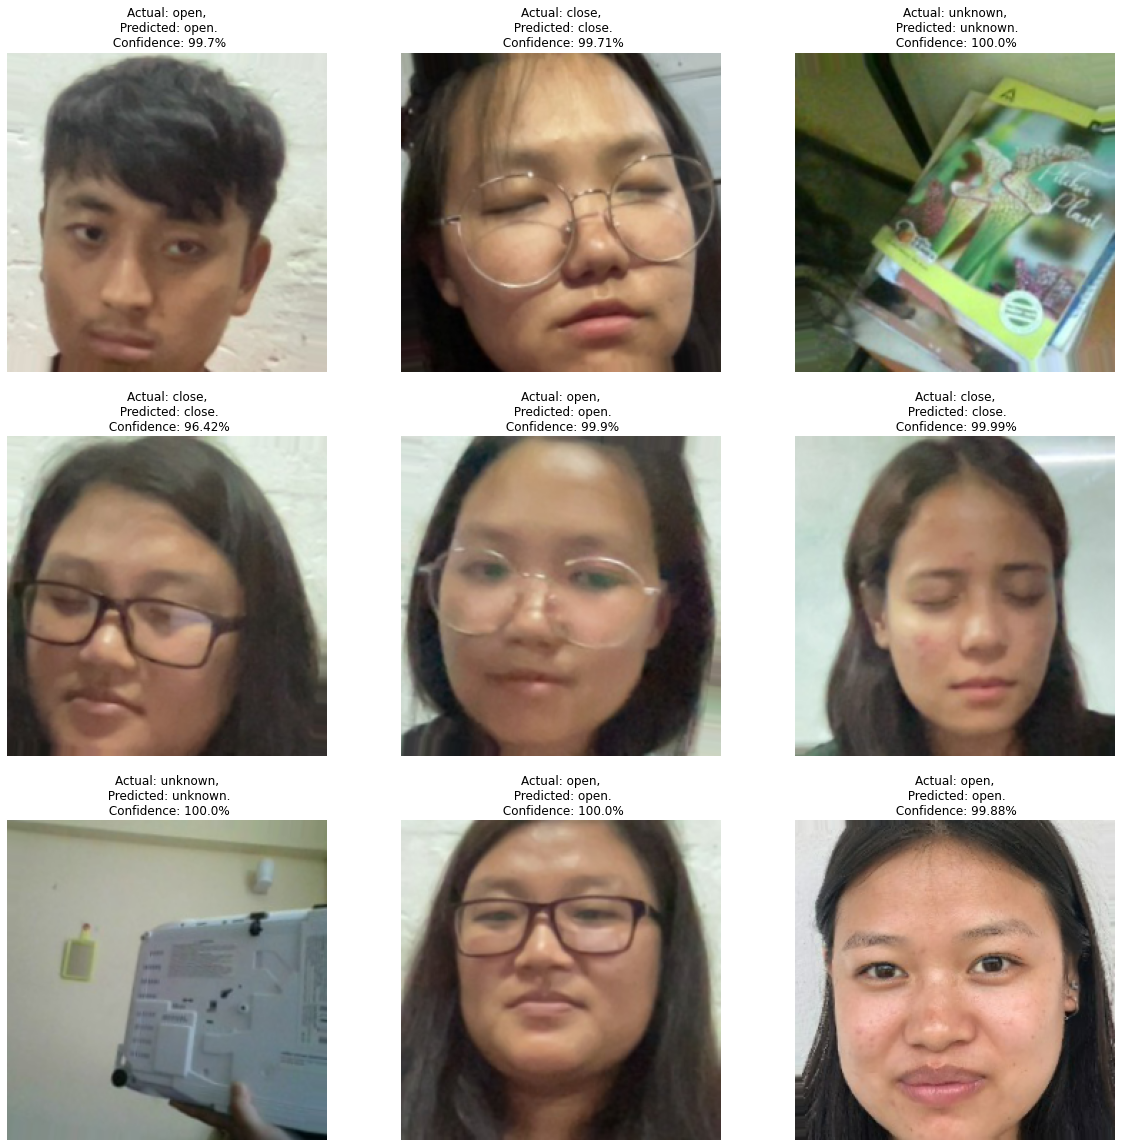

In [21]:
plt.figure(figsize=(20, 20))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

# Plotting the graph of Train and Validation Accuracy

Text(0.5, 1.0, ' Training  and Validation Accuracy')

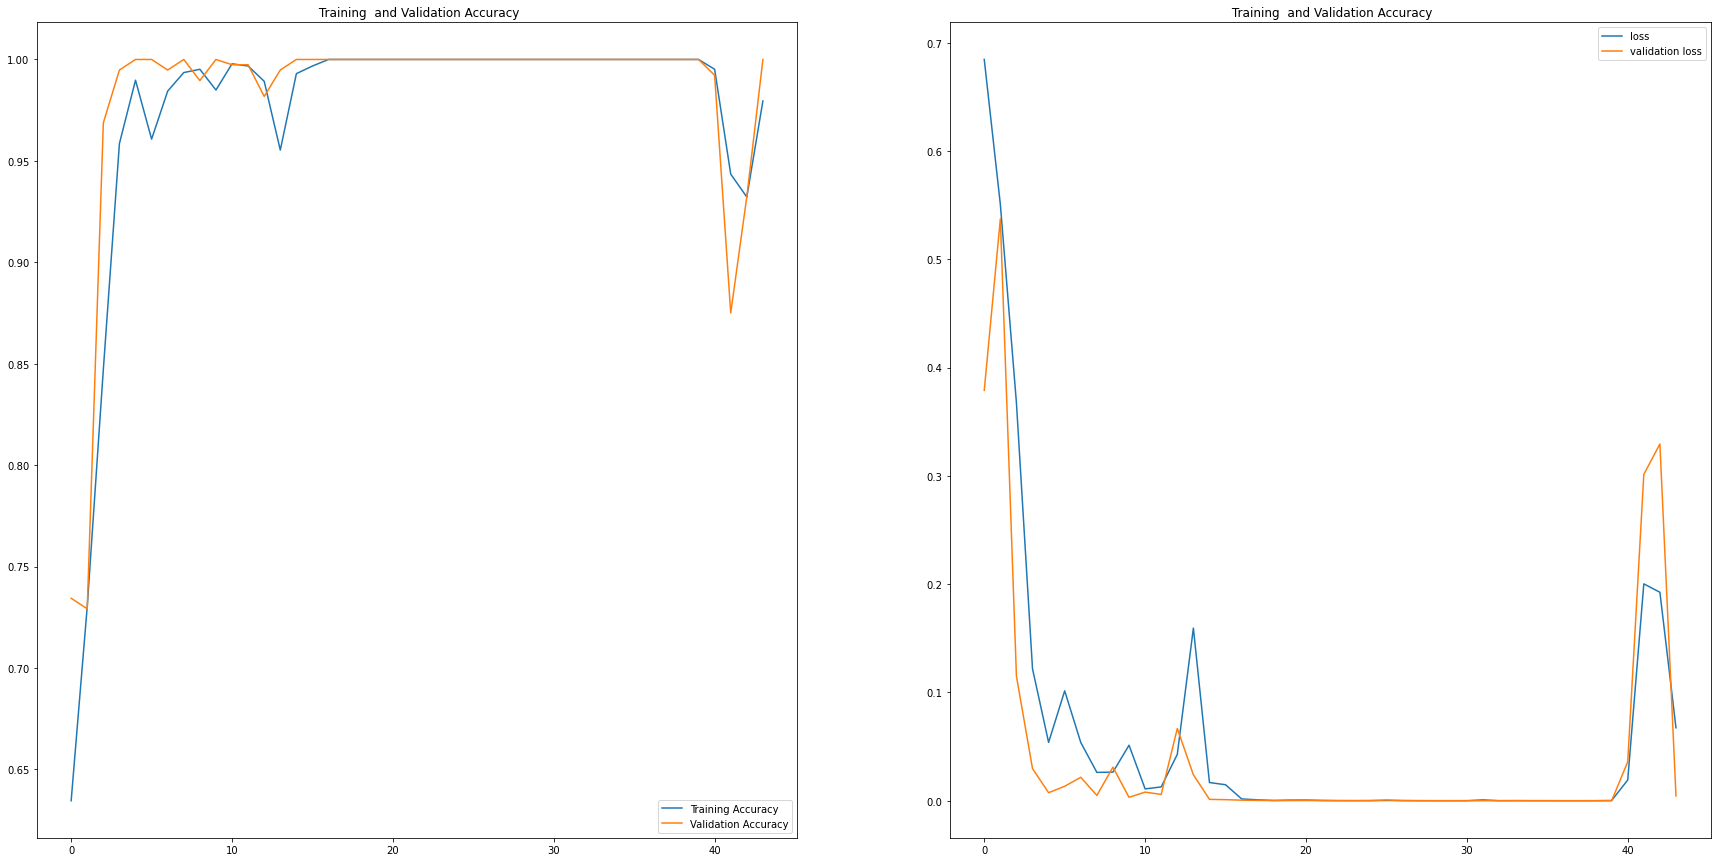

In [26]:
epochs = 44
plt.figure(figsize = (30, 15))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc , label ='Training Accuracy')
plt.plot(range(epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title(' Training  and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss , label ='loss')
plt.plot(range(epochs), val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title(' Training  and Validation Accuracy')

# Saving the model

In [36]:
model = model.save("drowsiness")

INFO:tensorflow:Assets written to: drowsiness\assets


INFO:tensorflow:Assets written to: drowsiness\assets


In [37]:
converter = tf.lite.TFLiteConverter.from_saved_model("drowsiness")
tflite_model = converter.convert()
with open('model_unquant.tflite', 'wb') as f:
    f.write(tflite_model)

In [38]:
converter1 = tf.lite.TFLiteConverter.from_saved_model("drowsiness")
converter1.optimization = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter1.convert()
with open("model.tflite", 'wb') as f:
    f.write(tflite_model_quant)
